# MISA PROJECT: BRAIN TISSUES SEGMENTATION
Segmenting GM WM and CSF of BRAIN MRI images

**Esteban Vaca, Sergio Tascon, Jhon Gomez**

*Universitat de Girona, Spain*


# 1.IMPORT DEPENDENCIES
---

First of all, import or install all necessary libraries and google drive. 


In [1]:
!pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.1.8/antspy-0.1.7-cp36-cp36m-linux_x86_64.whl
!pip install statsmodels
!pip install SimpleITK  

     |████████████████████████████████| 255.7MB 55kB/s 
     |████████████████████████████████| 42.5MB 72kB/s 


## Mount Google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Import the required libraries:
  
  Inide the imported libraries is possible to find the following packages:


*   Unet basic model
*   Training Functions
*   File managers
*   Early Stopping functions



In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/UNET')
from actions.find_ratio import find_ratio
from actions.early_stopping import EarlyStopping
from models.unet_instance_norm import UnetModel  
from utils.utils import *
from file_manager.file_manager import *
from actions.train_model import *
from actions.evaluate_subject import *
from metrics.metrics import calculate_dices
from models.models import Unet
from preprocessing.preprocessing import histogram_matching, normalize_images, bias_field_correction
import ants
import pandas as pd
from importlib import reload  # Py3 only; unneeded in py2.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


## 1.1.Data Loading
---

Let's now obtain the data to train and test the model. This data is available in google drive and will be copied to the colab directory to speed-up the training process. The data corresponds to the `IBSR18` dataset.

In [4]:
!mkdir data
!cp -r /content/gdrive/My\ Drive/MISAPROJ_REPORT data/dataset/
!ls data/dataset/Training_Set/IBSR_01/

IBSR_01.nii.gz	IBSR_01_norm.nii.gz  IBSR_01_ROI.nii.gz  IBSR_01_seg.nii.gz


This is the set of the Dataset IBSR18 and it is splited in three sets, training, validation and testing. Each case contains a `T1` image and its tissue segmentation. Manual annotations include white matter `class=1`, grey  matter  `class=2` and CSF `class=3`. 

Let's see a case as example: 

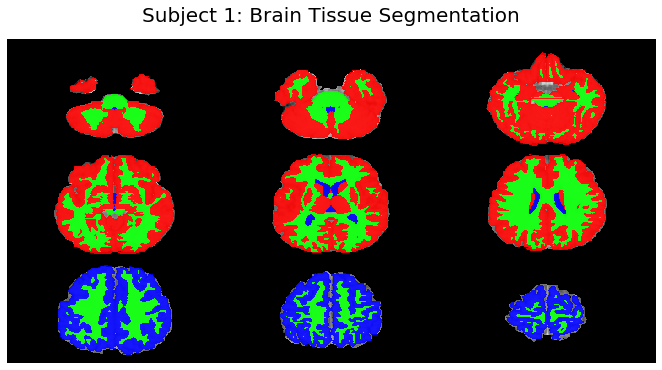

In [5]:
mri_subject = ants.image_read('data/dataset/Training_Set/IBSR_01/IBSR_01.nii.gz')
segmentation_mask = ants.image_read('data/dataset/Training_Set/IBSR_01/IBSR_01_seg.nii.gz')
mri_subject.plot(overlay=segmentation_mask, nslices=9, axis=2, title='Subject 1: Brain Tissue Segmentation', overlay_cmap = 'brg' )

# 2.Preprocess the data
---

We will perform an histogram matching to ensure that the intensities of all the images match.


In [0]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

fixed_path = '/content/data/dataset/Training_Set/IBSR_01/IBSR_01.nii.gz'
moving_path = '/content/data/dataset/Training_Set/IBSR_03/IBSR_03.nii.gz'
fixed_itk = sitk.ReadImage(fixed_path)
moving_itk = sitk.ReadImage(moving_path)
moving_matched_itk = histogram_matching(fixed_itk, moving_itk)
sitk.WriteImage(moving_matched_itk, '/content/data/dataset/Training_Set/IBSR_03/IBSR_03_norm.nii.gz')

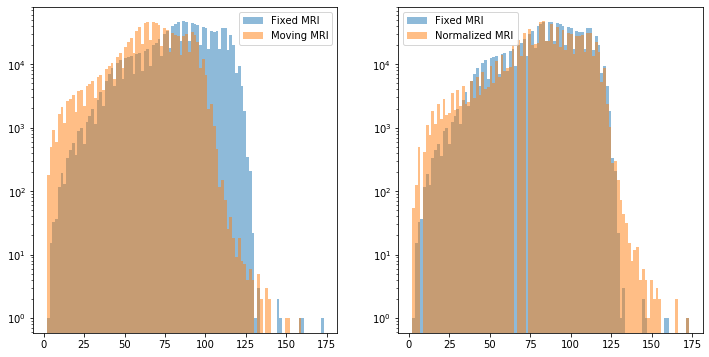

In [7]:
fixed_img = sitk.GetArrayFromImage(fixed_itk)
moving_img = sitk.GetArrayFromImage(moving_itk)
moving_matched_img = sitk.GetArrayFromImage(moving_matched_itk)

fig, ax = plt.subplots(1,2,figsize = (12, 6))
out_vals = ax[0].hist(fixed_img[fixed_img>0], 100, label = 'Fixed MRI', alpha = 0.5, log = True)
ax[0].hist(moving_img.ravel(), out_vals[1], label = 'Moving MRI', alpha = 0.5, log = True)
ax[0].legend()

out_vals = ax[1].hist(fixed_img[fixed_img>0], 100, label = 'Fixed MRI', alpha = 0.5, log = True)
ax[1].hist(moving_matched_img.ravel(), out_vals[1], label = 'Normalized MRI', alpha = 0.5, log = True)
ax[1].legend()

Additionaly we will get the ratio of the labels between CSF, GM, WM and background:

# 3.Data Preparation
---
Once we have our dataset in the colab memmory, we will proceed to build the training, validation and test structures for Pytorch which includes`Dataset` and `Dataloader` objects.


With the aim  to unify all the hyper-parameters and training options, we will define a dictionary `options` that we will populate with new values.

First we will include in options the folders where the dataset is located.

In [0]:
options = {}
# training data path
options['training_path'] = '/content/data/dataset/Training_Set'

# Validation data path 
options['val_path'] = '/content/data/dataset/Validation_Set'

# Validation data path 
options['test_path'] = '/content/data/dataset/Test_Set'

# train/validation split percentage
options['val_split']  = 0.5

Now we will create the region of interest of the MRI volumes. This will be stored in a folder called roi together with the dataset data.

In [9]:
create_ROIs(options['training_path'])
create_ROIs(options['val_path'])
create_ROIs(options['test_path'])

Creating ROI for:  IBSR_04
Creating ROI for:  IBSR_09
Creating ROI for:  IBSR_18
Creating ROI for:  IBSR_05
Creating ROI for:  IBSR_06
Creating ROI for:  IBSR_01
Creating ROI for:  IBSR_03
Creating ROI for:  IBSR_08
Creating ROI for:  IBSR_16
Creating ROI for:  IBSR_07
Creating ROI for:  IBSR_11
Creating ROI for:  IBSR_13
Creating ROI for:  IBSR_17
Creating ROI for:  IBSR_14
Creating ROI for:  IBSR_12


Now we will Normalize all the images in the dataset

In [10]:
normalize_images(options['training_path'], fixed_path, '.nii.gz')
normalize_images(options['val_path'], fixed_path, '.nii.gz')
normalize_images(options['test_path'], fixed_path, '.nii.gz')

Normalizing image :  IBSR_04
Normalizing image :  IBSR_09
Normalizing image :  IBSR_18
Normalizing image :  IBSR_05
Normalizing image :  IBSR_06
Normalizing image :  IBSR_01
Normalizing image :  IBSR_03
Normalizing image :  IBSR_08
Normalizing image :  IBSR_16
Normalizing image :  IBSR_07
Normalizing image :  IBSR_11
Normalizing image :  IBSR_13
Normalizing image :  IBSR_17
Normalizing image :  IBSR_14
Normalizing image :  IBSR_12


Now, we can define the input dictionaries for training and validation: 

In [11]:
input_dictionary = create_training_validation_sets(options)
print('Training Set:')
input_dictionary['input_train_data']

Training Set:


{'IBSR_01': ['/content/data/dataset/Training_Set/IBSR_01/IBSR_01_norm.nii.gz'],
 'IBSR_03': ['/content/data/dataset/Training_Set/IBSR_03/IBSR_03_norm.nii.gz'],
 'IBSR_04': ['/content/data/dataset/Training_Set/IBSR_04/IBSR_04_norm.nii.gz'],
 'IBSR_05': ['/content/data/dataset/Training_Set/IBSR_05/IBSR_05_norm.nii.gz'],
 'IBSR_06': ['/content/data/dataset/Training_Set/IBSR_06/IBSR_06_norm.nii.gz'],
 'IBSR_08': ['/content/data/dataset/Training_Set/IBSR_08/IBSR_08_norm.nii.gz'],
 'IBSR_09': ['/content/data/dataset/Training_Set/IBSR_09/IBSR_09_norm.nii.gz'],
 'IBSR_18': ['/content/data/dataset/Training_Set/IBSR_18/IBSR_18_norm.nii.gz']}

In [12]:
print('Validation Set:')
input_dictionary['input_val_data']

Validation Set:


{'IBSR_07': ['/content/data/dataset/Validation_Set/IBSR_07/IBSR_07_norm.nii.gz'],
 'IBSR_16': ['/content/data/dataset/Validation_Set/IBSR_16/IBSR_16_norm.nii.gz']}

Now we will set up other hiperparameters of the network, such as:

* Patch size of `32x32x32`
* Sampling step of `16x16x16`
* Batch size of `32`


In [0]:
# additional options for patch size, sampling step, normalization
options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (16, 16, 16)
options['normalize'] = True 
options['batch_size'] = 64

Now we will build the `Datasets` for training and validation data. Here, we need to define the patch size (in 3D), and how we are going to sample the images. Also consider image normalization (take it into account on testing also!). We normalize images with `mean=0` and `std=1`. In particular, we are going to use:

In [14]:
from torch.utils.data import DataLoader

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_dictionary['input_train_data'],
                                       labels=input_dictionary['input_train_labels'],
                                       rois=input_dictionary['input_train_rois'],
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'],
                                       sampling_type = 'balanced+roi',
                                       resample_csf = 5)

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)


print('_________________________________________________')
print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_dictionary['input_val_data'],
                                        labels=input_dictionary['input_val_labels'],
                                        rois=input_dictionary['input_val_rois'],
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

Training data: 
PADDED
> DATA: Loaded scan IBSR_04 roi size: 1069342 label_size:  1027700
PADDED
> DATA: Loaded scan IBSR_09 roi size: 1002429 label_size:  927415
PADDED
> DATA: Loaded scan IBSR_18 roi size: 1668281 label_size:  1590195
PADDED
> DATA: Loaded scan IBSR_05 roi size: 1040178 label_size:  950111
PADDED
> DATA: Loaded scan IBSR_06 roi size: 1078395 label_size:  977824
PADDED
> DATA: Loaded scan IBSR_01 roi size: 1147470 label_size:  1093813
PADDED
> DATA: Loaded scan IBSR_03 roi size: 951358 label_size:  899576
PADDED
> DATA: Loaded scan IBSR_08 roi size: 868943 label_size:  787260
Original samples:   2172 , Resampled  :  7752
> DATA: Training sample size: 7752
_________________________________________________
Validation data: 
PADDED
> DATA: Loaded scan IBSR_16 roi size: 1460808 label_size:  1385945
PADDED
> DATA: Loaded scan IBSR_07 roi size: 867764 label_size:  799514
Original samples:   570 , Resampled  :  570
> DATA: Training sample size: 570


Now we will get the data ratio to handle the imbalance of the dataset. We will calculate the ratio of data and a corresponding weight that will be used to train the model. 

In [15]:
ratio = find_ratio(training_dataset)
weights = 1 / ratio
print('Class ratio  : ', ratio)
print('Class weights: ', weights)

Class ratio  :  [0.35426724 0.1188033  0.29632398 0.23060548]
Class weights:  [2.82272782 8.41727495 3.37468471 4.33641031]


# 4.Build the U-Net Model and Train

Now that the data to feed the network is ready, we will initialize the U-Net model and we will start training it

In [0]:
model = UnetModel(in_chans=1, out_chans=4, chans=64, num_pool_layers=3, drop_prob=0.1)

Now we will set up some hyperparameters options such as:



*   Number of Epochs
*   Patience for Early Stopping




In [0]:
options['gpu_use'] = True
options['num_epochs'] = 200
options['model_name'] = 'unet_tissue_segmentation'
options['save_path'] = 'models' #'/content/gdrive/My Drive/misa_model_41/'
options['patience'] = 20
options['weights'] = weights
options['lr'] = 0.0001

In [0]:
!mkdir models

In [0]:
#model.load_state_dict(torch.load('checkpoint.pt'))

In [21]:
options['gpu_use']

True

In [22]:
options['lr'] = 0.0001
train_model(model, options, train ing_dataloader, validation_dataloader)

Weights not loaded.
Epoch 1 train_loss -1.8230 train_acc 0.6654 val_loss -2.3557 val_acc 0.8209 train_dice tensor([0.5463, 0.6811, 0.7038, 0.5941], device='cuda:0') val_dice tensor([0.7142, 0.8125, 0.7938, 0.8742], device='cuda:0')
Validation loss decreased (inf --> -2.355736).  Saving model ...
Epoch 2 train_loss -2.6405 train_acc 0.8311 val_loss -2.6044 val_acc 0.8728 train_dice tensor([0.7766, 0.8292, 0.8286, 0.8473], device='cuda:0') val_dice tensor([0.7973, 0.8714, 0.8294, 0.9278], device='cuda:0')
Validation loss decreased (-2.355736 --> -2.604373).  Saving model ...
Epoch 3 train_loss -2.8597 train_acc 0.8692 val_loss -2.6815 val_acc 0.8939 train_dice tensor([0.8401, 0.8661, 0.8603, 0.9002], device='cuda:0') val_dice tensor([0.8344, 0.8886, 0.8599, 0.9516], device='cuda:0')
Validation loss decreased (-2.604373 --> -2.681550).  Saving model ...
Epoch 4 train_loss -2.9358 train_acc 0.8840 val_loss -2.7218 val_acc 0.9047 train_dice tensor([0.8625, 0.8802, 0.8760, 0.9143], device='c

In [0]:
#model.load_state_dict(torch.load('/content/gdrive/My Drive/misa_model_41/unet_tissue_segmentation71.pt')) 
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
model = model.to(device)

# 5.Test the model

Once we have trained our first `Unet` model, we can infer some testing cases to see how well it performs. We are  going to use some additional helper functions included in `utils.py` that will help us to extract the image patches to infer the model:

* `get_inference_patches` will extract $[num_{samples}, 2, 32, 32, 32]$ patches from the input image along with their coordenates $(x,y,z)$. 

* `reconstruct_image` will take the predicted patches and reconstruct them back as an image using the coordinates as a  base. 

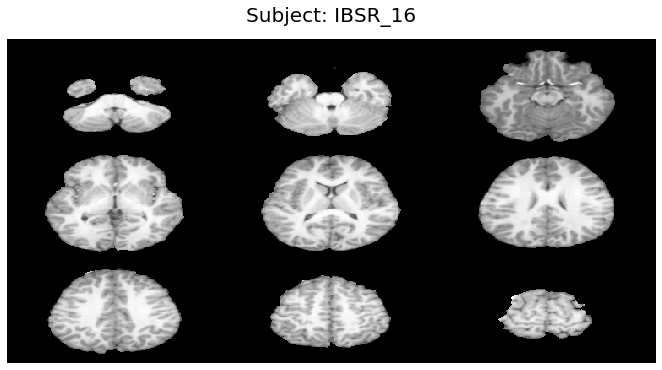

In [23]:
test_samples = list(input_dictionary['input_val_data'].keys())
scan_path = os.path.join(options['val_path'], test_samples[0])

# Visualize the image
scan = ants.image_read(os.path.join(scan_path, test_samples[0] + ".nii.gz"))
scan.plot(nslices=9, axis=2, title='Subject: '+test_samples[0] )

Now we will evaluate the segmentation result on the presented Subject, 
First we will show the result of the segmentation.

/content/gdrive/My Drive/UNET/utils/utils.py:499: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


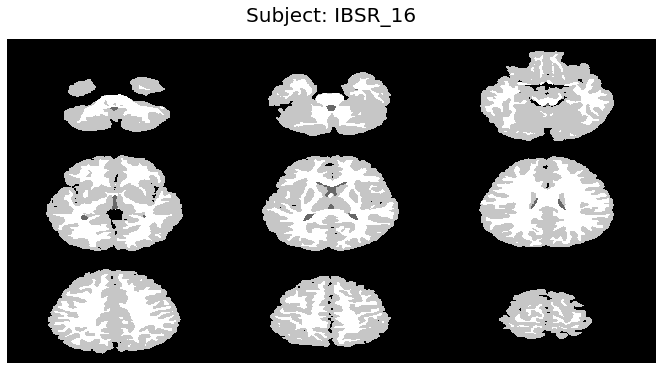

In [24]:
segm_img = evaluate_subject(scan_path, test_samples[0], options, model)
segm_img.plot(nslices=9, axis=2, title='Subject: '+test_samples[0] )

##Dice coefficients calculation for the Validation Set

Now we will evaluate the segmentation in all the images of the validation dataset.

In [25]:
# Join all the volumes to segment:
volumes_to_evaluate = {}
volumes_to_evaluate.update(input_dictionary['input_val_data'])

# Evaluate on all the samples:
test_samples = list(volumes_to_evaluate.keys())
evaluate_set(test_samples, options, model)

Evaluation volume:  IBSR_16


/content/gdrive/My Drive/UNET/utils/utils.py:499: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


Evaluation volume:  IBSR_07


,CSF,GM,WM
IBSR_16,0.859865,0.924257,0.891328
IBSR_07,0.914853,0.920505,0.907135


In [26]:
test_samples

['IBSR_16', 'IBSR_07']

# GENERATE MASKS:

In [27]:
# Join all the volumes to segment:
volumes_to_evaluate = {}
volumes_to_evaluate.update(input_dictionary['input_test_data'])

# Evaluate on all the samples:
test_samples = list(volumes_to_evaluate.keys())
dice_scores, avd_scores, hud_scores = evaluate_test_set(test_samples, options, model)
dice_scores

Evaluation volume:  IBSR_11


/content/gdrive/My Drive/UNET/utils/utils.py:499: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


Evaluation volume:  IBSR_13
Evaluation volume:  IBSR_17
Evaluation volume:  IBSR_14
Evaluation volume:  IBSR_12


,CSF,GM,WM
IBSR_11,0.912701,0.926566,0.925557
IBSR_13,0.902323,0.926438,0.899622
IBSR_17,0.939298,0.927427,0.902453
IBSR_14,0.920844,0.941384,0.926799
IBSR_12,0.875420,0.920959,0.922149


In [28]:
avd_scores

,CSF,GM,WM
IBSR_11,0.073257,0.043757,0.076545
IBSR_13,0.020458,0.075211,0.093606
IBSR_17,0.018794,0.056934,0.077720
IBSR_14,0.082606,0.009131,0.045467
IBSR_12,0.193523,0.015108,0.019255


In [29]:
hud_scores

,CSF,GM,WM
IBSR_11,20.736441,32.465366,31.717503
IBSR_13,29.427878,35.482390,32.062439
IBSR_17,25.159491,30.149627,30.133038
IBSR_14,21.863211,26.944387,27.531800
IBSR_12,21.307276,30.149627,31.559468


In [30]:
!zip  -r results_validation.zip /content/data/dataset/Test_Set

  adding: content/data/dataset/Test_Set/ (stored 0%)
  adding: content/data/dataset/Test_Set/IBSR_11/ (stored 0%)
  adding: content/data/dataset/Test_Set/IBSR_11/IBSR_11_norm.nii.gz (deflated 2%)
  adding: content/data/dataset/Test_Set/IBSR_11/IBSR_11_ROI.nii.gz (deflated 47%)
  adding: content/data/dataset/Test_Set/IBSR_11/IBSR_11_seg.nii.gz (deflated 11%)
  adding: content/data/dataset/Test_Set/IBSR_11/IBSR_11_result.nii.gz (deflated 6%)
  adding: content/data/dataset/Test_Set/IBSR_11/IBSR_11.nii.gz (deflated 1%)
  adding: content/data/dataset/Test_Set/IBSR_13/ (stored 0%)
  adding: content/data/dataset/Test_Set/IBSR_13/IBSR_13_ROI.nii.gz (deflated 49%)
  adding: content/data/dataset/Test_Set/IBSR_13/IBSR_13_result.nii.gz (deflated 6%)
  adding: content/data/dataset/Test_Set/IBSR_13/IBSR_13_seg.nii.gz (deflated 11%)
  adding: content/data/dataset/Test_Set/IBSR_13/IBSR_13.nii.gz (deflated 2%)
  adding: content/data/dataset/Test_Set/IBSR_13/IBSR_13_norm.nii.gz (deflated 2%)
  adding: c